# Tech Challenge -  FIAP
## Fase 3

O problema
Com base nas duas fases anteriores, você será responsável por criar um modelo de ML que siga algumas regras:

* Construa uma API que colete dados (se possível, em tempo real) e armazene isso em um banco de dados convencional, uma estrutura de DW ou até mesmo um Data Lake (se quiser, utilize a mesma ideia da fase 2, inclusive a fonte de dados).
* Construa um modelo de ML à sua escolha que utilize essa base de dados para treinar o mesmo.
* Seu modelo deve seguir com seu código no github e a devida documentação.
* Você deve ter uma apresentação visual do storytelling do seu modelo (contando todas as etapas realizadas até a entrega final por meio de um vídeo explicativo). O vídeo pode ser entregue através de um link do YouTube junto com o link do seu repositório do github, por meio de um arquivo txt via upload na plataforma online.
* Seu modelo deve ser produtivo (alimentar uma aplicação simples ou um dashboard).

## Previsão de Ativos da Bolsa B3 (2021–2025)

Este projeto visa construir modelos de Machine Learning preditivos com base em dados históricos da bolsa de valores brasileira (B3), utilizando Python.

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler, normalize, OneHotEncoder, LabelEncoder

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR, SVC
from sklearn.model_selection import GridSearchCV

import joblib

### Importação dos Dados

O dataset foi carregado a partir de um arquivo .csv contendo os dados de todos os ativos entre 2021 e 2025.
As colunas foram nomeadas de acordo com o layout conhecido:

- ativo: código do ativo
- data: data da operação
- abertura: preço de abertura
- máximo: preço máximo no dia
- mínimo: preço mínimo no dia
- fechamento: preço de fechamento
- volume: número de negociações

Realizamos a conversão da coluna de data e validamos os primeiros registros.
Os dados foram extraídos da plataforma MetaTrader.

In [22]:
file_path = "data/b3-tickers-raw.csv"
colunas = ['ativo', 'data', 'abertura', 'maximo', 'minimo', 'fechamento', 'volume']
df = pd.read_csv(file_path, names=colunas, encoding='utf-8', skiprows=1)
df.head()

,ativo,data,abertura,maximo,minimo,fechamento,volume
0,LUPA13F,2021.03.11,0.41,0.96,0.36,0.50,395
1,LUPA13F,2021.03.12,0.45,0.45,0.26,0.27,210
2,LUPA13F,2021.03.15,0.26,0.26,0.18,0.21,120
3,LUPA13F,2021.03.16,0.20,0.20,0.15,0.16,90
4,LUPA13F,2021.03.17,0.15,0.60,0.15,0.52,320


### Análise Exploratória de Dados (EDA)

Explorar o conjunto de dados para entender melhor sua estrutura, identificar possíveis outliers, valores ausentes e tendências históricas. Para podermos criar features para os modelos.


In [23]:
# Formatando o campo de data
df['data'] = pd.to_datetime(df['data'], format='%Y.%m.%d')

# Separando dataset com meses fechados Min 2020-05-21 00:00:00	Máx 2025-05-19 00:00:00
df = df[(df['data'] >= '2020-06-01 00:00:00') & (df['data'] < '2025-05-01 00:00:00')]
display(df.describe())
print(f'Valores nulos por coluna:{df.isnull().sum()}')

,data,abertura,maximo,minimo,fechamento,volume
count,454599,454599.000000,454599.000000,454599.000000,454599.000000,454599.000000
mean,2022-12-10 14:33:15.082259456,20.653803,21.052867,20.232827,20.632905,877.622318
min,2020-06-01 00:00:00,0.010000,0.010000,0.010000,0.010000,1.000000
25%,2021-09-29 00:00:00,5.810000,5.950000,5.660000,5.800000,31.000000
50%,2022-12-19 00:00:00,12.250000,12.500000,12.000000,12.240000,222.000000
75%,2024-02-29 00:00:00,24.980000,25.370000,24.500000,24.960000,858.000000
max,2025-04-30 00:00:00,4000.000000,4000.000000,4000.000000,4000.000000,176271.000000
std,NaN,42.323339,42.792825,41.883766,42.353082,2171.709093


Valores nulos por coluna:ativo         0
data          0
abertura      0
maximo        0
minimo        0
fechamento    0
volume        0
dtype: int64


### Criação de Features

Variáveis Numéricas:

| Variável | O que faz|
| ------------------- | ------------------------------------------- |
| `retorno_diario` | Variação percentual do fechamento dia a dia |
| `valor_mm_5` / `valor_mm_20`| Médias móveis de 5 e 20 dias |
| `volatilidade_5`| Desvio padrão de 5 dias do fechamento |
| `retorno_acumulado`| Retorno acumulado desde o início da série |
| `abertura_mm_5` / `abertura_mm_20`| Médias móveis 5 e 20 dias do valor de abertura |
| `volume_mm_5` / `volume_mm_20`| Médias móveis 5 e 20 dias do volume negociado |

Vairiáveis Tempo:
| Variável            | O que faz                                   |
| ------------------- | ------------------------------------------- |
| `dia_semana`        | Número do dia da semana                     |
| `mes`               | Mês numérico                                |

Variáveis Categórica
| Variável               | O que faz                                                          |
| ---------------------- | ------------------------------------------------------------------ |
| `fechamento_categoria` | Compara um dia contra o anterior e classifica igual, abaixo, acima |
| `volume_categoria`     | Compara um dia contra o anterior e classifica igual, abaixo, acima |

In [24]:
# Ordena os dados para cada ativo
df = df.sort_values(by=['ativo', 'data']).reset_index(drop=True)

# Função para processar as features por ativo
def criar_features(grupo):
    grupo = grupo.copy()
    
    # Variáveis numéricas
    grupo['retorno_diario'] = grupo['fechamento'].pct_change()
    grupo['valor_mm_5'] = grupo['fechamento'].rolling(window=5).mean()
    grupo['valor_mm_20'] = grupo['fechamento'].rolling(window=20).mean()
    grupo['volatilidade_5'] = grupo['fechamento'].rolling(window=5).std()
    grupo['retorno_acumulado'] = (1 + grupo['retorno_diario']).cumprod() - 1
    
    grupo['abertura_mm_5'] = grupo['abertura'].rolling(window=5).mean()
    grupo['abertura_mm_20'] = grupo['abertura'].rolling(window=20).mean()
    
    grupo['volume_mm_5'] = grupo['volume'].rolling(window=5).mean()
    grupo['volume_mm_20'] = grupo['volume'].rolling(window=20).mean()

    # Criar colunas de valores anteriores
    grupo['fechamento_anterior'] = grupo['fechamento'].shift(1)
    grupo['volume_anterior'] = grupo['volume'].shift(1)

    # Variáveis categóricas
    grupo['fechamento_categoria'] = np.select(
        [
            grupo['fechamento'] > grupo['fechamento_anterior'],
            grupo['fechamento'] < grupo['fechamento_anterior']
        ],
        ['acima', 'abaixo'],
        default='igual'
    )

    grupo['volume_categoria'] = np.select(
        [
            grupo['volume'] > grupo['volume_anterior'],
            grupo['volume'] < grupo['volume_anterior']
        ],
        ['acima', 'abaixo'],
        default='igual'
    )

    return grupo

# Aplica a função para cada ticker
df = df.groupby('ativo', group_keys=False).apply(criar_features).reset_index(drop=True)

# Variáveis temporais
df['dia_semana'] = df['data'].dt.dayofweek
df['mes'] = df['data'].dt.month

colunas_para_remover = ['fechamento_anterior', 'volume_anterior']
df = df.drop(colunas_para_remover, axis=1)

# Remove linhas com NaNs causados pelas janelas (rolling ou shift)
df = df.dropna().reset_index(drop=True)
df.head()

/var/folders/n0/50rdwt1d4zs30_njzqs1fb1h0000gn/T/ipykernel_33336/3375598418.py:47: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('ativo', group_keys=False).apply(criar_features).reset_index(drop=True)


,ativo,data,abertura,maximo,minimo,fechamento,volume,retorno_diario,valor_mm_5,valor_mm_20,volatilidade_5,retorno_acumulado,abertura_mm_5,abertura_mm_20,volume_mm_5,volume_mm_20,fechamento_categoria,volume_categoria,dia_semana,mes
0,AALR3F,2020-06-29,10.33,10.42,10.00,10.14,291,-0.005882,10.436,11.1015,0.297792,-0.025000,10.696,11.1185,453.8,585.50,abaixo,abaixo,0,6
1,AALR3F,2020-06-30,10.13,10.49,10.08,10.30,276,0.015779,10.336,11.0965,0.218358,-0.009615,10.412,11.1105,340.8,527.70,acima,abaixo,1,6
2,AALR3F,2020-07-01,10.29,10.58,10.24,10.34,347,0.003883,10.336,11.0910,0.218358,-0.005769,10.314,11.1060,309.8,500.85,acima,acima,2,7
3,AALR3F,2020-07-02,10.41,10.90,10.05,10.15,687,-0.018375,10.226,11.0485,0.089889,-0.024038,10.328,11.1020,381.2,508.95,abaixo,acima,3,7
4,AALR3F,2020-07-03,10.12,10.22,9.92,10.11,331,-0.003941,10.208,10.9790,0.104259,-0.027885,10.256,11.0530,386.4,508.55,abaixo,abaixo,4,7


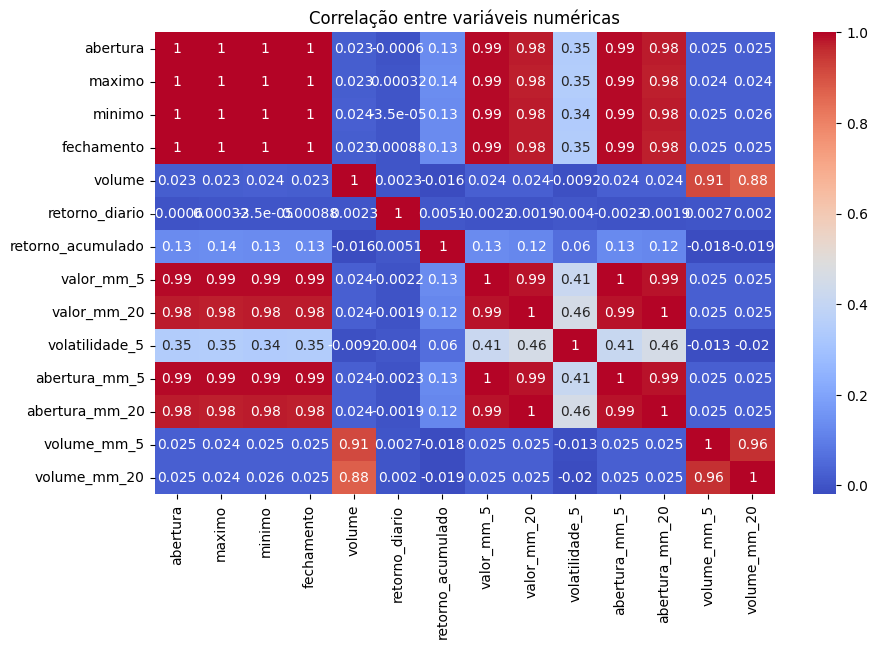

In [25]:
plt.figure(figsize=(10, 6))
sns.heatmap(df[['abertura', 'maximo', 'minimo', 'fechamento', 'volume', 'retorno_diario', 'retorno_acumulado', 'valor_mm_5', 'valor_mm_20', 'volatilidade_5', 'abertura_mm_5', 'abertura_mm_20', 'volume_mm_5', 'volume_mm_20']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlação entre variáveis numéricas')
plt.show()

### Modelos

Regressão Linear

In [26]:
df['fechamento_proximo'] = df.groupby('ativo')['fechamento'].shift(-1)
df = df.dropna().reset_index(drop=True)

features_num = ['retorno_diario', 'valor_mm_5', 'valor_mm_20', 'volatilidade_5', 'retorno_acumulado', 'abertura_mm_5', 'abertura_mm_20', 'volume_mm_5', 'volume_mm_20']
features_cat = ['dia_semana', 'mes', 'volume_categoria']
target_reg = 'fechamento_proximo'
target_clf = 'fechamento_categoria'

In [27]:
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), features_num),
    ('cat', OneHotEncoder(drop='first'), features_cat)
])

In [28]:
x_reg = df[features_num + features_cat]
y_reg = df[target_reg]

In [29]:
x_train_r, x_test_r, y_train_r, y_test_r = train_test_split(x_reg, y_reg, test_size=0.3, random_state=42)

In [30]:
pipeline_reg = Pipeline([
    ('prep', preprocessor),
    ('model', LinearRegression()) 
])

pipeline_reg.fit(x_train_r, y_train_r)
y_pred_r = pipeline_reg.predict(x_test_r)

print("Regressão (Fechamento Próximo):")
print("RMSE:", np.sqrt(mean_squared_error(y_test_r, y_pred_r)))

mape = mean_absolute_percentage_error(y_test_r, y_pred_r)
print(f'MAPE (Regressão): {mape}')

Regressão (Fechamento Próximo):
RMSE: 4.987290697204271
MAPE (Regressão): 0.05550662178801839


Árvore de Decisão

In [31]:
pipeline_tree = Pipeline([
    ('prep', preprocessor),
    ('model', DecisionTreeRegressor()) 
])

pipeline_tree.fit(x_train_r, y_train_r)
y_pred_r = pipeline_reg.predict(x_test_r)

print("Regressão (Fechamento Próximo):")
print("RMSE:", np.sqrt(mean_squared_error(y_test_r, y_pred_r)))

mape = mean_absolute_percentage_error(y_test_r, y_pred_r)
print(f'MAPE (Regressão): {mape}')

Regressão (Fechamento Próximo):
RMSE: 4.987290697204271
MAPE (Regressão): 0.05550662178801839


Regressão Logística

In [ ]:
label_encoder = LabelEncoder()
df['fechamento_categoria_encoded'] = label_encoder.fit_transform(df[target_clf])

X_clf = df[features_num + features_cat]
y_clf = df['fechamento_categoria_encoded']

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_clf, y_clf, test_size=0.2, random_state=42)

pipeline_clf = Pipeline([
    ('prep', preprocessor),
    ('model', LogisticRegression(max_iter=1000))
])

pipeline_clf.fit(X_train_c, y_train_c)
y_pred_c = pipeline_clf.predict(X_test_c)

print("Classificação (Categoria do Fechamento):")
print("Acurácia:", accuracy_score(y_test_c, y_pred_c))
print(classification_report(y_test_c, y_pred_c, target_names=label_encoder.classes_))


🔍 Classificação (Categoria do Fechamento):
Acurácia: 0.9550727078771546
              precision    recall  f1-score   support

      abaixo       0.94      1.00      0.97     43836
       acima       0.97      1.00      0.98     41090
       igual       0.65      0.09      0.16      4129

    accuracy                           0.96     89055
   macro avg       0.85      0.69      0.70     89055
weighted avg       0.94      0.96      0.94     89055



# Export PKL para APIs

In [33]:
joblib.dump(pipeline_reg, 'pipeline_reg.pkl')
joblib.dump(pipeline_tree, 'pipeline_tree.pkl')
joblib.dump(pipeline_clf, 'pipeline_clf.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')

['label_encoder.pkl']